In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import gc
import re

from tqdm import tqdm
from collections import Counter

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore')

# change to path
PATH='/content/drive/My Drive/Colab Notebooks/grab/'
os.chdir(PATH)

In [0]:
PATH_LABELS = PATH + 'safety/labels'
PATH_FEATURES = PATH + 'safety/features'

## Read in

In [0]:
labels_df = pd.read_csv(f'{PATH_LABELS}/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

In [5]:
sub_df = pd.read_pickle(f'{PATH_FEATURES}/sub_df_100.pkl')

sub_df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
0,0,16.0,142.124496,-0.660800,-9.543246,-1.814920,-0.002753,-0.035185,0.014585,183.0,0.227891,0
1,0,8.0,315.071838,-0.674707,-9.464740,-1.566092,-0.001937,-0.019093,0.009868,942.0,2.682516,0
2,0,16.0,144.125198,-1.183429,-8.491260,-3.712085,0.022289,-0.002134,0.052846,123.0,11.216825,0
3,0,16.0,243.958252,-0.600388,-11.128629,-0.485394,-0.034949,-0.021853,-0.012370,241.0,3.728397,0
4,0,8.0,38.000866,-0.889590,-8.826669,-1.920493,0.041287,-0.017650,0.033933,1037.0,12.354941,0


In [6]:
len(sub_df)

1998200

## EDA

In [7]:
sub_df.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,label
count,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06,1.998200e+06
mean,8.161654e+11,1.061140e+01,1.684718e+02,7.244688e-02,4.579389e+00,9.075932e-01,-2.046001e-03,2.152561e-05,-2.651337e-04,4.199983e+03,8.423657e+00,2.493744e-01
std,4.944606e+11,7.623948e+01,1.078981e+02,1.407409e+00,8.070876e+00,3.221037e+00,1.423460e-01,3.193392e-01,1.516832e-01,1.517685e+06,7.825821e+00,4.326510e-01
min,0.000000e+00,7.500000e-01,0.000000e+00,-2.687987e+01,-5.203878e+01,-5.711064e+01,-2.927131e+01,-5.887993e+01,-2.818092e+01,0.000000e+00,-1.000000e+00,0.000000e+00
25%,3.865471e+11,3.900000e+00,7.655327e+01,-5.049608e-01,-6.440599e-01,-9.171051e-01,-2.670214e-02,-3.027998e-02,-1.878666e-02,1.660000e+02,8.132748e-01,0.000000e+00
50%,7.988639e+11,4.288000e+00,1.690000e+02,6.026306e-02,9.107821e+00,7.709565e-01,-6.933320e-04,2.288818e-04,-7.629395e-05,3.940000e+02,6.730000e+00,0.000000e+00
75%,1.245541e+12,8.000000e+00,2.630000e+02,6.343323e-01,9.713572e+00,2.743839e+00,2.282715e-02,3.158569e-02,1.810950e-02,6.940000e+02,1.435960e+01,0.000000e+00
max,1.709397e+12,6.063000e+03,3.599967e+02,5.134041e+01,5.838979e+01,7.288908e+01,1.830983e+01,5.550382e+01,4.505986e+01,6.193158e+08,8.803725e+01,1.000000e+00


## Feature engineering

In [0]:
sub_df.columns.tolist()

['bookingID',
 'Accuracy',
 'Bearing',
 'acceleration_x',
 'acceleration_y',
 'acceleration_z',
 'gyro_x',
 'gyro_y',
 'gyro_z',
 'second',
 'Speed',
 'label']

In [0]:
def total_acc(df):
    # acceleration combining all directions
    total_acc = np.power(df['acceleration_x'].values, 2) + \
                np.power(df['acceleration_y'].values, 2) + \
                np.power(df['acceleration_z'].values, 2)
    
    df['total_acc'] = np.sqrt(total_acc)
    
def total_gyro(df):
    # gyro combining all directions
    total_gyro = np.power(df['gyro_x'].values, 2) + \
                 np.power(df['gyro_y'].values, 2) + \
                 np.power(df['gyro_z'].values, 2)
    
    df['total_gyro'] = np.sqrt(total_gyro)
    
total_acc(sub_df)
total_gyro(sub_df)

In [0]:
accs = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'total_acc']
gyros = ['gyro_x', 'gyro_y', 'gyro_z', 'total_gyro']
speed = ['Speed']

features = accs + gyros + speed

def group_features(in_, features):
    # features grouped by bookingID
    out_ = pd.DataFrame()
    
    out_['bookingID'] = in_['bookingID'].unique()
    
    def first_order(x):
        # first order diff
        return np.mean(np.diff(x))

    def second_order(x):
        # second order diff
        return np.mean(np.diff(np.diff(x)))   
    
    # statistical features
    for feature in features:
            
        out_[feature + '_mean'] = in_.groupby('bookingID')[feature].mean().values        
        out_[feature + '_min'] = in_.groupby('bookingID')[feature].min().values
        out_[feature + '_max'] = in_.groupby('bookingID')[feature].max().values
        out_[feature + '_std'] = in_.groupby('bookingID')[feature].std().values
        
        out_[feature + '_fo_mean'] = in_.groupby('bookingID')[feature]\
                                            .apply(first_order).values  
        out_[feature + '_so_mean'] = in_.groupby('bookingID')[feature]\
                                            .apply(second_order).values                
    return out_

In [0]:
new = group_features(sub_df, features)

In [0]:
new.head()

,bookingID,acceleration_x_mean,acceleration_x_min,acceleration_x_max,acceleration_x_std,acceleration_x_fo_mean,acceleration_x_so_mean,acceleration_y_mean,acceleration_y_min,acceleration_y_max,acceleration_y_std,acceleration_y_fo_mean,acceleration_y_so_mean,acceleration_z_mean,acceleration_z_min,acceleration_z_max,acceleration_z_std,acceleration_z_fo_mean,acceleration_z_so_mean,total_acc_mean,total_acc_min,total_acc_max,total_acc_std,total_acc_fo_mean,total_acc_so_mean,gyro_x_mean,gyro_x_min,gyro_x_max,gyro_x_std,gyro_x_fo_mean,gyro_x_so_mean,gyro_y_mean,gyro_y_min,gyro_y_max,gyro_y_std,gyro_y_fo_mean,gyro_y_so_mean,gyro_z_mean,gyro_z_min,gyro_z_max,gyro_z_std,gyro_z_fo_mean,gyro_z_so_mean,total_gyro_mean,total_gyro_min,total_gyro_max,total_gyro_std,total_gyro_fo_mean,total_gyro_so_mean,Speed_mean,Speed_min,Speed_max,Speed_std,Speed_fo_mean,Speed_so_mean
0,0,-0.648598,-2.889038,3.626102,0.964882,-0.004571,0.002483,-9.617283,-12.764703,-8.093045,0.683734,-0.002101,-0.007799,-1.648758,-5.800656,1.784265,1.213740,0.002936,0.006258,9.901510,8.357991,12.988328,0.662304,0.001975,0.005938,-0.001491,-0.230967,0.347489,0.071442,0.000113,0.000233,-0.015799,-0.379043,0.377282,0.106781,0.000545,0.000167,-0.007324,-0.284009,0.209767,0.059477,-0.000295,0.000185,0.101683,0.013322,0.484473,0.099541,-0.000131,0.000072,7.844813,0.064309,21.240761,6.861628,2.134613e-03,-1.985995e-01
1,1,-0.515797,-2.370662,3.387767,0.675866,0.005570,0.005714,9.547557,7.771339,10.728791,0.502611,0.000484,0.011288,-2.176563,-4.806848,-0.062996,0.865198,-0.002507,0.018813,9.870474,8.455773,10.871560,0.422207,0.000737,0.005228,-0.001604,-0.054210,0.061959,0.021566,0.000323,0.000089,-0.019800,-0.573742,0.210347,0.085879,-0.000085,-0.000627,-0.001443,-0.062675,0.136467,0.026840,0.000283,-0.000057,0.056473,0.003648,0.589819,0.075762,0.000401,-0.001011,7.213234,-1.000000,21.858812,6.792266,1.036210e-01,-2.316663e-01
2,2,0.365558,-1.728666,1.834015,0.699327,-0.013205,0.004715,9.835035,8.248277,11.559559,0.440514,-0.002733,-0.000464,0.180456,-3.282551,2.312870,1.021426,-0.003845,0.013999,9.919853,8.334944,11.718406,0.449217,-0.003073,-0.000383,0.008800,-0.155218,0.241234,0.057002,0.000031,-0.000480,-0.023570,-0.462000,0.297305,0.116870,0.003005,-0.002980,0.002607,-0.084979,0.255884,0.039991,-0.000315,0.000131,0.100827,0.005845,0.463685,0.094258,-0.002705,0.002360,3.126265,0.000000,9.360483,2.848020,2.691450e-17,4.531523e-18
3,4,-0.297979,-2.650528,1.785162,0.598809,-0.020397,0.018062,-9.445157,-15.253134,-8.106802,0.719555,0.003562,-0.003339,-2.579531,-5.193839,-0.906488,0.774801,-0.034721,-0.012042,9.842355,8.554923,16.157423,0.741068,0.004631,0.010151,-0.024235,-0.113330,0.094424,0.029816,0.000165,-0.001267,0.022005,-0.343034,0.477722,0.119418,-0.002787,0.001673,0.011805,-0.108571,0.234811,0.054717,-0.000210,0.001258,0.106024,0.022119,0.481976,0.089510,-0.002550,0.001770,6.079600,0.000000,18.480000,5.383002,9.696969e-03,-1.014286e-01
4,6,0.424960,-3.047912,2.250618,0.760655,-0.005901,-0.001099,9.644498,8.166871,12.823736,0.655483,0.005442,0.005277,2.417116,-1.438959,6.038361,1.063747,0.001475,-0.004153,10.034272,8.603480,14.498268,0.689889,0.005427,0.003892,0.004045,-0.200405,0.243694,0.054953,0.000154,-0.000150,0.002277,-0.513678,0.380017,0.108827,0.000012,0.005124,-0.006090,-0.135764,0.222203,0.047414,-0.000056,0.001297,0.086772,0.005723,0.518669,0.097802,-0.000157,-0.004697,3.884060,0.000000,15.783421,5.010923,-2.467162e-17,-1.206307e-02


In [107]:
new_labels = pd.merge(new, labels_df,
                      left_on='bookingID', right_on='bookingID',
                      how='inner')

new_labels.head()

,bookingID,acceleration_x_mean,acceleration_x_min,acceleration_x_max,acceleration_x_std,acceleration_x_fo_mean,acceleration_x_so_mean,acceleration_y_mean,acceleration_y_min,acceleration_y_max,acceleration_y_std,acceleration_y_fo_mean,acceleration_y_so_mean,acceleration_z_mean,acceleration_z_min,acceleration_z_max,acceleration_z_std,acceleration_z_fo_mean,acceleration_z_so_mean,total_acc_mean,total_acc_min,total_acc_max,total_acc_std,total_acc_fo_mean,total_acc_so_mean,gyro_x_mean,gyro_x_min,gyro_x_max,gyro_x_std,gyro_x_fo_mean,gyro_x_so_mean,gyro_y_mean,gyro_y_min,gyro_y_max,gyro_y_std,gyro_y_fo_mean,gyro_y_so_mean,gyro_z_mean,gyro_z_min,gyro_z_max,gyro_z_std,gyro_z_fo_mean,gyro_z_so_mean,total_gyro_mean,total_gyro_min,total_gyro_max,total_gyro_std,total_gyro_fo_mean,total_gyro_so_mean,Speed_mean,Speed_min,Speed_max,Speed_std,Speed_fo_mean,Speed_so_mean,label
0,0,-0.648598,-2.889038,3.626102,0.964882,-0.004571,0.002483,-9.617283,-12.764703,-8.093045,0.683734,-0.002101,-0.007799,-1.648758,-5.800656,1.784265,1.213740,0.002936,0.006258,9.901510,8.357991,12.988328,0.662304,0.001975,0.005938,-0.001491,-0.230967,0.347489,0.071442,0.000113,0.000233,-0.015799,-0.379043,0.377282,0.106781,0.000545,0.000167,-0.007324,-0.284009,0.209767,0.059477,-0.000295,0.000185,0.101683,0.013322,0.484473,0.099541,-0.000131,0.000072,7.844813,0.064309,21.240761,6.861628,2.134613e-03,-1.985995e-01,0
1,1,-0.515797,-2.370662,3.387767,0.675866,0.005570,0.005714,9.547557,7.771339,10.728791,0.502611,0.000484,0.011288,-2.176563,-4.806848,-0.062996,0.865198,-0.002507,0.018813,9.870474,8.455773,10.871560,0.422207,0.000737,0.005228,-0.001604,-0.054210,0.061959,0.021566,0.000323,0.000089,-0.019800,-0.573742,0.210347,0.085879,-0.000085,-0.000627,-0.001443,-0.062675,0.136467,0.026840,0.000283,-0.000057,0.056473,0.003648,0.589819,0.075762,0.000401,-0.001011,7.213234,-1.000000,21.858812,6.792266,1.036210e-01,-2.316663e-01,1
2,2,0.365558,-1.728666,1.834015,0.699327,-0.013205,0.004715,9.835035,8.248277,11.559559,0.440514,-0.002733,-0.000464,0.180456,-3.282551,2.312870,1.021426,-0.003845,0.013999,9.919853,8.334944,11.718406,0.449217,-0.003073,-0.000383,0.008800,-0.155218,0.241234,0.057002,0.000031,-0.000480,-0.023570,-0.462000,0.297305,0.116870,0.003005,-0.002980,0.002607,-0.084979,0.255884,0.039991,-0.000315,0.000131,0.100827,0.005845,0.463685,0.094258,-0.002705,0.002360,3.126265,0.000000,9.360483,2.848020,2.691450e-17,4.531523e-18,1
3,4,-0.297979,-2.650528,1.785162,0.598809,-0.020397,0.018062,-9.445157,-15.253134,-8.106802,0.719555,0.003562,-0.003339,-2.579531,-5.193839,-0.906488,0.774801,-0.034721,-0.012042,9.842355,8.554923,16.157423,0.741068,0.004631,0.010151,-0.024235,-0.113330,0.094424,0.029816,0.000165,-0.001267,0.022005,-0.343034,0.477722,0.119418,-0.002787,0.001673,0.011805,-0.108571,0.234811,0.054717,-0.000210,0.001258,0.106024,0.022119,0.481976,0.089510,-0.002550,0.001770,6.079600,0.000000,18.480000,5.383002,9.696969e-03,-1.014286e-01,1
4,6,0.424960,-3.047912,2.250618,0.760655,-0.005901,-0.001099,9.644498,8.166871,12.823736,0.655483,0.005442,0.005277,2.417116,-1.438959,6.038361,1.063747,0.001475,-0.004153,10.034272,8.603480,14.498268,0.689889,0.005427,0.003892,0.004045,-0.200405,0.243694,0.054953,0.000154,-0.000150,0.002277,-0.513678,0.380017,0.108827,0.000012,0.005124,-0.006090,-0.135764,0.222203,0.047414,-0.000056,0.001297,0.086772,0.005723,0.518669,0.097802,-0.000157,-0.004697,3.884060,0.000000,15.783421,5.010923,-2.467162e-17,-1.206307e-02,0


## Feature selection

In [0]:
lgb_features = [c for c in sub_df.columns if c not in ['label', 'bookingID']]

# useless_features = []

# exclude = []

## Baseline

In [0]:
random_state = 42
np.random.seed(random_state)

folds=5
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

In [0]:
X_train = sub_df[lgb_features]
y_train = sub_df['label'].values

val_aucs = []
feature_importance_df = pd.DataFrame()

oof = sub_df[['bookingID', 'label']]
oof['predict'] = 0

In [0]:
# len(oof), len(X_train), len(y_train)

train = sub_df

features = [c for c in train.columns if c not in ['bookingID', 'label']]

In [0]:
oof = oof.reset_index()

In [0]:
# for i,(train_index,test_index) in enumerate(kf.split(X_train, y_train)):

#     tr_x = X_train.iloc[train_index]
#     tr_y = y_train[train_index]
#     te_x = X_train.iloc[test_index]
#     te_y = y_train[test_index]

#     d_train = lgb.Dataset(tr_x, label=tr_y)
#     d_valid = lgb.Dataset(te_x, label=te_y)
    
#     watchlist = [d_valid, d_train]
    
#     evals_result = {}

#     n_estimators=500

#     lgb_params = {"objective" : "binary",
#                   "metric" : "auc",
#                   "boosting": 'gbdt',
#                   "max_depth" : -1,
#                   "num_leaves" : 13,
#                   "learning_rate" : 0.05,
#                   "bagging_freq": 5,
#                   "bagging_fraction" : 0.4,
#                   "feature_fraction" : 0.05,
#                   "min_data_in_leaf": 80,
#                   "min_sum_heassian_in_leaf": 10,
#                   "tree_learner": "serial",
#                   "boost_from_average": "false",
# #                       "lambda_l1" : 5,
# #                       "lambda_l2" : 5,
#                   "bagging_seed" : random_state,
#                   "verbosity" : 1,
#                   "seed": random_state}


#     lgb_clf = lgb.train(lgb_params, 
#                         d_train, 
#                         n_estimators, 
#                         valid_sets=watchlist, 
#                         evals_result=evals_result,
#                         early_stopping_rounds=100,
#                         verbose_eval=100)

#     fold_importance_df = pd.DataFrame()
#     fold_importance_df["feature"] = lgb_features
#     fold_importance_df["importance"] = lgb_clf.feature_importance()
#     fold_importance_df["fold"] = i + 1
#     feature_importance_df = pd.concat([feature_importance_df, 
#                                        fold_importance_df], axis=0)

#     p_valid = lgb_clf.predict(te_x, 
#                               num_iteration=lgb_clf.best_iteration)

#     oof['predict'][test_index] = p_valid
#     val_score = roc_auc_score(te_y, p_valid)
#     val_aucs.append(val_score)
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.7,
    'min_data_in_leaf': 200,
    'bagging_fraction': 0.8,
    'bagging_freq': 20,
    'min_hessian': 0.01,
    'feature_fraction_seed': 2,
    'bagging_seed': 3,
    "seed": random_state
}

for fold, (trn_idx, val_idx) in enumerate(skf.split(train, train['label'])):
    X_train, y_train = train.iloc[trn_idx][features], train.iloc[trn_idx]['label']
    X_valid, y_valid = train.iloc[val_idx][features], train.iloc[val_idx]['label']
    
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    evals_result = {}
    
    lgb_clf = lgb.train(lgb_params,
                        trn_data,
                        500,
                        valid_sets=[trn_data, val_data],
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        evals_result=evals_result)

    p_valid = lgb_clf.predict(X_valid[features], num_iteration=lgb_clf.best_iteration)

    oof['predict'][val_idx] = p_valid
    val_score = roc_auc_score(y_valid, p_valid)
    val_aucs.append(val_score)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.658245	valid_1's auc: 0.658316
[200]	training's auc: 0.663738	valid_1's auc: 0.662572
[300]	training's auc: 0.667773	valid_1's auc: 0.665116
[400]	training's auc: 0.671572	valid_1's auc: 0.667433
[500]	training's auc: 0.674936	valid_1's auc: 0.669323
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.674936	valid_1's auc: 0.669323
Training until validation scores don't improve for 100 rounds.


In [157]:
mean_auc = np.mean(val_aucs)
std_auc = np.std(val_aucs)
all_auc = roc_auc_score(oof['label'], oof['predict'])
print("Mean auc: %.9f, std: %.9f. All auc: %.9f." % (mean_auc, std_auc, all_auc))

Mean auc: 0.605546682, std: 0.007548349. All auc: 0.601817029.


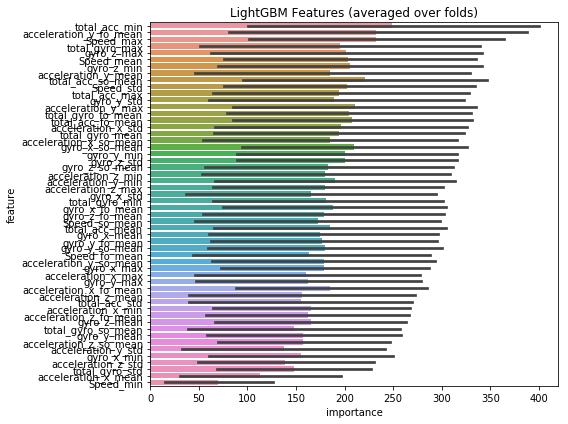

In [158]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')